<a href="https://colab.research.google.com/github/ashok-arora/ML-Zoomcamp/blob/main/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 13:25:41--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2021-10-03 13:25:41 (6.95 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [ ]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [ ]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [ ]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [ ]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [ ]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [ ]:
categorical = df.select_dtypes(include=['object']).columns
categorical

Index(['home', 'marital', 'records', 'job'], dtype='object')

In [ ]:
numerical = df.select_dtypes(exclude=['object']).columns
numerical

Index(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
       'amount', 'price', 'default'],
      dtype='object')

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [ ]:
train_split = 0.80
test_split = 0.20


df_full_train, df_test = train_test_split(df, test_size=test_split, random_state=1)

# validation split = 20% of 80% of training data
val_split = test_split / train_split
df_train, df_val = train_test_split(df_full_train, test_size=val_split, random_state=1)

print(len(df), len(df_train), len(df_val), len(df_test))

4454 2672 891 891


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [ ]:
auc_scores = {}
target_variable = df_train['default']
for feature in numerical:
    auc_score = roc_auc_score(target_variable, df_train[feature])
    if auc_score < 0.5:
        auc_score = roc_auc_score(df_train.default, -df_train[feature])
    auc_scores[feature] = auc_score

sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

[('default', 1.0),
 ('seniority', 0.7093778624491943),
 ('income', 0.682006666132633),
 ('assets', 0.6486042567122802),
 ('amount', 0.5910773431595518),
 ('age', 0.5732933272499939),
 ('time', 0.5608662489595051),
 ('debt', 0.5047829675783548),
 ('price', 0.5043329862114843),
 ('expenses', 0.5009184217217011)]

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [ ]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
target_feature = 'default'

X_full_train = df_full_train[features]
X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

y_full_train = df_full_train[target_feature]
y_train = df_train[target_feature]
y_val = df_val[target_feature]
y_test = df_test[target_feature]

In [ ]:
X_train_dict = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train_one_hot = dv.fit_transform(X_train_dict)

In [ ]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_one_hot, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [ ]:
X_val_dict = X_val.to_dict(orient='records')
X_ohe = dv.transform(X_val_dict)
score = roc_auc_score(y_val, model.predict_proba(X_ohe)[:, 1])
round(score, 3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [ ]:
thresholds = np.arange(0, 1, step=0.01)

precisions = []
recalls = []

import warnings
warnings.filterwarnings('ignore')

for threshold in thresholds:
    X_val_dict = X_val.to_dict(orient='records')
    X_ohe = dv.transform(X_val_dict)
    
    precision = precision_score(y_val, (model.predict_proba(X_ohe)[:, 1] >= threshold))
    recall = recall_score(y_val, (model.predict_proba(X_ohe)[:, 1] >= threshold))
    
    precisions.append(precision)
    recalls.append(recall)

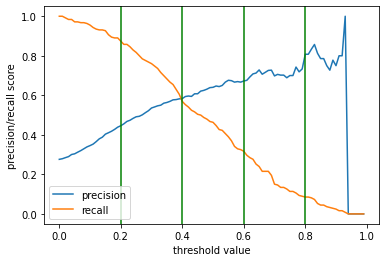

In [ ]:
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')

plt.xlabel('threshold value')
plt.ylabel('precision/recall score')

for x in [0.2, 0.4, 0.6, 0.8]:
  plt.axvline(x=x, color='green')

plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [ ]:
P = np.array(precisions)
R = np.array(recalls)

F1 = 2*(P*R)/(P+R)
idx = list(F1).index(max(F1))
thresholds[idx]

0.3

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_index, val_index in kf.split(X_full_train):
    X_train = X_full_train.iloc[train_index]
    y_train = y_full_train.iloc[train_index]
    X_val = X_full_train.iloc[val_index]
    y_val = y_full_train.iloc[val_index]

    X_train_dict = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)

    X_train_one_hot = dv.fit_transform(X_train_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train_one_hot, y_train)

    score = roc_auc_score(y_val, model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1])
    scores.append(score)

scores

[0.8256212256212256,
 0.8254077031563474,
 0.789298525308888,
 0.8153421373265731,
 0.8054696294614563]

In [ ]:
np.std(scores)

0.013669069470482898

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [ ]:
mean_scores = []
std_scores = []
Cs = [0.01, 0.1, 1, 10]
for C in Cs:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_index, val_index in kf.split(X_full_train):
        X_train = X_full_train.iloc[train_index]
        y_train = y_full_train.iloc[train_index]
        X_val = X_full_train.iloc[val_index]
        y_val = y_full_train.iloc[val_index]

        X_train_dict = X_train.to_dict(orient='records')

        dv = DictVectorizer(sparse=False)

        X_train_one_hot = dv.fit_transform(X_train_dict)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

        model.fit(X_train_one_hot, y_train)

        score = roc_auc_score(y_val, model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1])
        scores.append(score)
        
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

mean_scores, std_scores

([0.8076876665463588,
  0.8129017360952779,
  0.812227844174898,
  0.8141433397756099],
 [0.011832148394108436,
  0.013740829347711075,
  0.013669069470482898,
  0.014614166612648758])

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [ ]:
list(zip(Cs, mean_scores, std_scores))

[(0.01, 0.8076876665463588, 0.011832148394108436),
 (0.1, 0.8129017360952779, 0.013740829347711075),
 (1, 0.812227844174898, 0.013669069470482898),
 (10, 0.8141433397756099, 0.014614166612648758)]

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.